In [1]:
import numpy as np

import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
import seaborn as sns
from typing import List, Set, Dict, Tuple

In [2]:
train_source_loc = 'naver/train_source.txt'
train_target_loc = 'naver/train_target.txt'

test_source_loc = 'naver/test_source.txt'
test_target_loc = 'naver/test_target.txt'

In [3]:
def open_process(file_loc):
    file = open(file_loc, 'r')
    file_lines = file.readlines()
    file_lines = [list(map(int, line.split())) for line in file_lines]
    return file_lines

In [4]:
train_source = open_process(train_source_loc)
train_target = open_process(train_target_loc)

test_source = open_process(test_source_loc)
test_target = open_process(test_target_loc)

train_src_vocab = set([i for line in train_source for i in line])
train_tgt_vocab = set([i for line in train_target for i in line])

test_src_vocab = set([i for line in test_source for i in line])
test_tgt_vocab = set([i for line in test_target for i in line])

train_src_vocab_dict = {value: idx for idx, value in enumerate(sorted(train_src_vocab))}
train_tgt_vocab_dict = {value: idx for idx, value in enumerate(sorted(train_tgt_vocab))}

test_src_vocab_dict = {value: idx for idx, value in enumerate(sorted(test_src_vocab))}
test_tgt_vocab_dict = {value: idx for idx, value in enumerate(sorted(test_tgt_vocab))}

train_src_vocab_size = len(train_src_vocab)
train_tgt_vocab_size = len(train_tgt_vocab)

test_src_vocab_size = len(test_src_vocab)
test_tgt_vocab_size = len(test_tgt_vocab)

In [5]:
train_source = [[train_src_vocab_dict[i] for i in seq] for seq in train_source]
train_target = [[train_tgt_vocab_dict[i] for i in seq] for seq in train_target]

test_source = [[test_src_vocab_dict[i] for i in seq] for seq in test_source]
test_target = [[test_tgt_vocab_dict[i] for i in seq] for seq in test_target]

68의 존재는 무엇인가

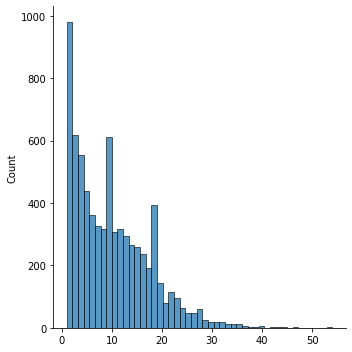

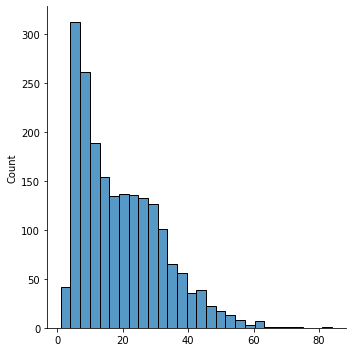

In [8]:
train_target_len = list(map(len, train_target))
sns.displot(train_target_len)

test_source_len = list(map(len, test_source))
sns.displot(test_source_len)

In [47]:
print(f'train source length: {len(train_source)}')
print(f'mean length: {int(np.mean([len(i) for i in train_source]))}')
print(f'max / min length: {len(max(train_source, key=len)), len(min(train_source, key=len))}')
print(f'vocab size: {len(train_src_vocab)}')
print('='*30)

print(f'train target length: {len(train_target)}')
print(f'mean length: {int(np.mean([len(i) for i in train_target]))}')
print(f'max / min length: {len(max(train_target, key=len)), len(min(train_target, key=len))}')
print(f'vocab size: {len(train_tgt_vocab)}')

print(f'test source length: {len(test_source)}')
print(f'mean length: {int(np.mean([len(i) for i in test_source]))}')
print(f'max / min length: {len(max(test_source, key=len)), len(min(test_source, key=len))}')
print(f'vocab size: {len(test_src_vocab)}')

print(f'test target length: {len(test_target)}')
print(f'mean length: {int(np.mean([len(i) for i in test_target]))}')
print(f'max / min length: {len(max(test_target, key=len)), len(min(test_target, key=len))}')
print(f'vocab size: {len(test_tgt_vocab)}')

train source length: 7260
mean length: 18
max / min length: (81, 2)
vocab size: 53
train target length: 7260
mean length: 10
max / min length: (54, 1)
vocab size: 595
test source length: 2000
mean length: 19
max / min length: (84, 1)
vocab size: 45
test target length: 2000
mean length: 10
max / min length: (54, 1)
vocab size: 495


In [9]:
class SeqDataset(Dataset):
    def __init__(self, src_seq: List, tgt_seq: List):
        self.src_seq = src_seq
        self.tgt_seq = tgt_seq
        
        self.src_maxlen = len(max(self.src_seq, key=len))
        self.tgt_maxlen = len(max(self.tgt_seq, key=len))
        
    def __len__(self)-> int:
        return len(self.src_seq)
    
    def __getitem__(self, idx: int) -> List:
        src = torch.tensor(self.src_seq[idx])
        tgt = torch.tensor(self.tgt_seq[idx])
        
        return src, tgt
    
def pad_collate(batch) -> (List, List):
    (xs, ys)= zip(*batch)
    
    x_lens = [len(x) for x in xs]
    y_lens = [len(y) for y in ys]

    x_pad = pad_sequence(xs, batch_first=True, padding_value=-1)
    y_pad = pad_sequence(ys, batch_first=True, padding_value=-1)
    
    return x_pad, y_pad

In [10]:
batch_size = 8

seq_dataset = SeqDataset(train_source, train_target)
seq_dataloader = DataLoader(seq_dataset, batch_size=batch_size, shuffle=True, collate_fn = pad_collate)

In [11]:
class Model(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(Model, self).__init__()

        # Defining some parameters
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        #Defining the layers
        # RNN Layer
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)   
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_size)
    
    def forward(self, x):
        
        batch_size = x.size(0)

        # Initializing hidden state for first input using method defined below
        hidden = self.init_hidden(batch_size)

        # Passing in the input and hidden state into the model and obtaining outputs
        out, hidden = self.rnn(x, hidden)
        
        # Reshaping the outputs such that it can be fit into the fully connected layer
        out = out.contiguous().view(-1, self.hidden_dim)
        out = self.fc(out)
        
        return out, hidden
    
    def init_hidden(self, batch_size):
        # This method generates the first hidden state of zeros which we'll use in the forward pass
        # We'll send the tensor holding the hidden state to the device we specified earlier as well
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim)
        return hidden

In [12]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [13]:
# Instantiate the model with hyperparameters
model = Model(input_size=train_src_vocab_size, output_size=train_tgt_vocab_size, hidden_dim=300, n_layers=20)
# We'll also set the model to the device that we defined earlier (default is CPU)
model.to(device)

Model(
  (rnn): RNN(53, 300, num_layers=20, batch_first=True)
  (fc): Linear(in_features=300, out_features=595, bias=True)
)

In [14]:
# Define hyperparameters
n_epochs = 100
lr=0.01

# Define Loss, Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [24]:
rnn = nn.RNN(input_size=train_src_vocab_size, hidden_size=300, num_layers=100, batch_first=True)   

In [26]:
input_seq

tensor([[15, 20, 42,  4,  8, 15, 22, 20, 41, 13, 10, 15,  4,  4, 15, 50, 22,  8,
         20, 15, 10, 41, 35, -1, -1, -1, -1, -1, -1],
        [25, 41, 40, 40, 50, 35, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
        [30, 15, 22, 15, 22, 39,  8,  6, 23, 13, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
        [33, 50, 36,  8, 40, 50, 50, 52,  8, 33, 50, 36, 22, 39,  8, 32, 50, 13,
          8, 33, 50, 36, 13,  8, 23, 39, 41, 35, -1],
        [15, 22,  4, 50, 10, 22, 15, 23, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
        [15,  8,  6, 23, 22, 42, 20,  8,  4, 41, 41, 35,  8,  3, 40, 41, 23,  4,
         41,  8,  4, 15, 20,  8, 30, 50,  2, 22, 35],
        [20, 25, 13, 41, 41, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
        [ 6, 23, 22,  8, 15,  8, 39, 41, 20,  8, 20, 25

In [25]:
rnn(input_seq)

RuntimeError: input.size(-1) must be equal to input_size. Expected 53, got 29

In [18]:
for epoch in range(1, n_epochs+1):
    for input_seq, target_seq in seq_dataloader:
        print(input_seq.shape)
        print(target_seq)
        optimizer.zero_grad()
        input_seq.to(device)
        output, hidden = model(input_seq)
        loss = criterion(output, target_seq.view(-1).long())
        loss.backward()
        optimizer.step()
        print('end')
        
    if epoch % 10 == 0:
        print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
        print("Loss: {:.4f}".format(loss.item()))

torch.Size([8, 29])
tensor([[297, 492,  59, 380, 264, 458, 100,  59, 116, 424,  -1,  -1,  -1,  -1,
          -1,  -1],
        [201,  44,  74,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
          -1,  -1],
        [ 77, 134,  64,  59, 290,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
          -1,  -1],
        [  4,  59, 439,  59, 393,  59, 211,  59,   4, 164,  59, 300, 134, 174,
          -1,  -1],
        [380, 395, 228, 544,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
          -1,  -1],
        [544, 134,  59, 468, 316,  59, 289,  59,  55, 184,  92,  59, 466,  59,
          77, 432],
        [369, 184,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
          -1,  -1],
        [468,  59, 544, 134,  59, 516,  59,  18,  73,  59, 380,  59, 322, 380,
         174,  -1]])


RuntimeError: For unbatched 2-D input, hx should also be 2-D but got 3-D tensor

In [55]:
# Training Run
for epoch in range(1, n_epochs + 1):
    optimizer.zero_grad() # Clears existing gradients from previous epoch
    input_seq.to(device)
    output, hidden = model(input_seq)
    loss = criterion(output, target_seq.view(-1).long())
    loss.backward() # Does backpropagation and calculates gradients
    optimizer.step() # Updates the weights accordingly
    
    if epoch%10 == 0:
        print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
        print("Loss: {:.4f}".format(loss.item()))

RuntimeError: For unbatched 2-D input, hx should also be 2-D but got 3-D tensor

In [41]:
len(max(train_source, key=len))

81

In [44]:
train_source_list = list(set([i for line in train_source for i in line]))

In [45]:
train_source_list

{21,
 23,
 29,
 33,
 35,
 40,
 52,
 57,
 68,
 73,
 78,
 83,
 92,
 95,
 103,
 105,
 109,
 113,
 128,
 130,
 140,
 156,
 157,
 200,
 202,
 227,
 228,
 229,
 263,
 268,
 271,
 289,
 304,
 311,
 320,
 327,
 342,
 369,
 382,
 402,
 416,
 437,
 453,
 455,
 456,
 497,
 498,
 513,
 557,
 575,
 584,
 601,
 619}